# Credit Card Fraud Detection - CatBoost Model

This notebook trains a CatBoost classifier for credit card fraud detection.

**Key advantages of CatBoost:**
- Native categorical feature support (no encoding needed)
- Built-in class imbalance handling via `auto_class_weights='Balanced'`
- Ordered boosting helps with imbalanced data
- Often achieves better PR-AUC than XGBoost on imbalanced tabular data

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

root_dir = Path().absolute()
# Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
if root_dir.parts[-1:] == ('notebooks',):
    root_dir = Path(*root_dir.parts[:-1])
    sys.path.append(str(root_dir))
if root_dir.parts[-1:] == ('ccfraud',):
    root_dir = Path(*root_dir.parts[:-1])
    sys.path.append(str(root_dir))
root_dir = str(root_dir) 

print(f"Root dir: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Root dir: /home/jdowling/Projects/mlfs-book
HopsworksSettings initialized!


In [2]:
import hopsworks
import pandas as pd
import shutil

proj = hopsworks.login()
fs = proj.get_feature_store()
mr = proj.get_model_registry()

2026-01-16 23:48:09,525 INFO: Initializing external client
2026-01-16 23:48:09,525 INFO: Base URL: https://eu-west.cloud.hopsworks.ai:443
2026-01-16 23:48:10,949 INFO: Python Engine initialized.

Logged in to project, explore it here https://eu-west.cloud.hopsworks.ai:443/p/120


## Feature View Setup

In [3]:
merchant_fg = fs.get_feature_group("merchant_details", version=1)
account_fg = fs.get_feature_group("account_details", version=1)
bank_fg = fs.get_feature_group("bank_details", version=1)
card_fg = fs.get_feature_group("card_details", version=1)
cc_trans_aggs_fg = fs.get_feature_group("cc_trans_aggs_fg", version=1)
cc_trans_fg = fs.get_feature_group("cc_trans_fg", version=1)

In [4]:
subtree1 = cc_trans_aggs_fg.select_except(['t_id','cc_num','account_id','bank_id','event_time'])\
    .join(account_fg.select(['debt_end_prev_month']), on="account_id")\
    .join(bank_fg.select(['credit_rating', 'days_since_bank_cr_changed', 'country']), on="bank_id")

In [5]:
selection = cc_trans_fg.select_except(['t_id', 'cc_num', 'merchant_id', 'account_id', 'ip_address', 'ts'])\
    .join(merchant_fg.select_features(), prefix="merchant_", on="merchant_id")\
    .join(subtree1, on="cc_num")

2026-01-16 23:48:16,701 INFO: Using ['category', 'country', 'cnt_chrgeback_prev_day', 'cnt_chrgeback_prev_week', 'cnt_chrgeback_prev_month'] from feature group `merchant_details` as features for the query. To include primary key and event time use `select_all`.


In [ ]:
fv = fs.get_or_create_feature_view(name="cc_fraud_fv", 
                                   version=1, 
                                   description="features for a credit card fraud prediction model",
                                   query=selection,
                                   labels=['is_fraud'],
                                   inference_helper_columns=['prev_card_present','prev_ip_address','prev_ts'],
                                   logging_enabled=True
                                  )

## Train/Test Split

In [7]:
# Parameters (injected by papermill)
test_start = "2026-01-09 00:00"

In [8]:
X_train, X_test, y_train, y_test = fv.train_test_split(test_start=test_start)
X_train

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (9.09s) 
2026-01-16 23:48:46,268 INFO: Computing insert statistics
2026-01-16 23:48:46,495 INFO: Computing insert statistics


,amount,time_since_last_trans,days_to_card_expiry,haversine_distance,merchant_category,merchant_country,merchant_cnt_chrgeback_prev_day,merchant_cnt_chrgeback_prev_week,merchant_cnt_chrgeback_prev_month,num_trans_last_10_mins,...,num_trans_last_hour,sum_trans_last_hour,num_trans_last_day,sum_trans_last_day,num_trans_last_week,sum_trans_last_week,debt_end_prev_month,credit_rating,days_since_bank_cr_changed,country
0,615.89,-2590795,0,True,Pet Supplies,Japan,0.50,3.19,15.80,1,...,1,615.89,1,615.89,1,615.89,1310.69,10,40,Germany
1,45.31,-2569702,0,True,Electronics,China,2.30,13.17,61.51,1,...,1,45.31,1,45.31,1,45.31,2907.37,10,40,Germany
2,24.11,-2578949,0,True,Education,Germany,0.47,3.45,12.53,1,...,1,24.11,1,24.11,1,24.11,1442.48,10,40,Germany
3,160.20,-2589467,0,True,Electronics,China,2.30,13.17,61.51,1,...,1,160.20,1,160.20,1,160.20,1012.91,10,40,Germany
4,6.64,-2587400,0,True,Education,Germany,0.47,3.45,12.53,1,...,1,6.64,1,6.64,1,6.64,3171.56,10,40,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455954,21.95,4526,0,True,Books,United Kingdom,0.51,3.01,13.95,1,...,1,21.95,5,190.04,48,2671.23,4784.69,10,262,Mexico
455955,12.65,691,0,False,Home Improvement,Japan,1.14,8.99,28.87,1,...,2,34.60,6,202.69,52,3105.49,4784.69,10,262,Mexico
455956,22.94,8503,0,True,Pet Supplies,Argentina,1.71,12.99,46.21,1,...,1,22.94,10,1142.91,57,6081.61,4570.14,10,262,Mexico
455957,412.30,4044,0,True,Fashion,Australia,0.60,3.96,20.22,1,...,1,412.30,7,1285.74,46,3929.25,58.69,10,262,Mexico


In [9]:
X_test

,amount,time_since_last_trans,days_to_card_expiry,haversine_distance,merchant_category,merchant_country,merchant_cnt_chrgeback_prev_day,merchant_cnt_chrgeback_prev_week,merchant_cnt_chrgeback_prev_month,num_trans_last_10_mins,...,num_trans_last_hour,sum_trans_last_hour,num_trans_last_day,sum_trans_last_day,num_trans_last_week,sum_trans_last_week,debt_end_prev_month,credit_rating,days_since_bank_cr_changed,country
12517,5.56,12373,0,False,Beauty,Japan,0.12,0.71,3.62,1,...,1,5.56,7,633.17,42,2935.98,1310.69,10,40,Germany
12518,56.24,4203,0,True,Books,Italy,2.34,18.76,67.88,1,...,1,56.24,7,267.17,32,1219.52,4021.56,10,40,Germany
12519,32.52,4582,0,True,Beauty,Mexico,8.43,54.55,297.70,1,...,1,32.52,8,1042.32,49,3498.73,1012.91,10,40,Germany
12520,84.26,5116,0,True,Books,Italy,0.56,4.35,18.94,1,...,1,84.26,5,233.52,43,2409.43,3053.01,10,40,Germany
12521,74.63,3139,0,True,Education,Germany,0.47,3.45,12.53,1,...,2,98.80,9,720.81,50,3148.80,3171.56,10,40,Germany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457191,31.36,5607,0,True,Beauty,South Korea,0.42,3.06,14.65,1,...,1,31.36,5,507.36,42,3027.78,3185.13,10,262,Mexico
457192,4.36,18275,0,True,Books,United Kingdom,0.51,3.01,13.95,1,...,1,4.36,1,4.36,15,1450.06,2425.80,10,262,Mexico
457193,16.57,27167,0,True,Beauty,South Korea,0.42,3.06,14.65,1,...,1,16.57,8,366.14,50,2307.78,3238.68,10,262,Mexico
457194,11.35,4928,0,True,Entertainment,France,0.38,2.34,13.21,1,...,1,11.35,10,722.30,63,4384.05,1723.58,10,262,Mexico


In [10]:
y_train.value_counts()

is_fraud
False       357071
True          1866
Name: count, dtype: int64

## Simplified Preprocessing for CatBoost

CatBoost handles categorical features natively, so we only need:
- Impute missing numeric values with median
- Impute missing categorical values with 'UNKNOWN'
- **No OrdinalEncoder needed!**

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

print("CREATING SIMPLIFIED PREPROCESSING PIPELINE FOR CATBOOST")
print("Missing values before preprocessing:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])

# Identify numeric and categorical columns
categorical_features = ['merchant_category', 'merchant_country', 'country']
numeric_features = [col for col in X_train.columns if col not in categorical_features]

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# For CatBoost, we handle preprocessing differently:
# 1. Create a copy of the data
# 2. Fill categorical NaN values directly in pandas (preserves string type)
# 3. Use SimpleImputer only for numeric columns

X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Fill categorical missing values with 'UNKNOWN' (preserves string dtype for CatBoost)
for col in categorical_features:
    X_train_processed[col] = X_train_processed[col].fillna('UNKNOWN').astype(str)
    X_test_processed[col] = X_test_processed[col].fillna('UNKNOWN').astype(str)

# Create numeric-only preprocessor for imputation
numeric_imputer = SimpleImputer(strategy='median')
X_train_processed[numeric_features] = numeric_imputer.fit_transform(X_train_processed[numeric_features])
X_test_processed[numeric_features] = numeric_imputer.transform(X_test_processed[numeric_features])

# Also create the full preprocessor for saving (inference pipeline)
# Numeric pipeline: just impute missing values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline: just impute missing values (CatBoost handles encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='UNKNOWN'))
])

# Combine into a single ColumnTransformer for saving
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False
)
# Fit the preprocessor on training data (for saving)
_ = preprocessor.fit(X_train)

# Get feature names
feature_names_out = list(X_train_processed.columns)

print("\nAfter preprocessing:")
print(f"  Missing values: {X_train_processed.isnull().sum().sum()}")
print(f"  Train shape: {X_train_processed.shape}")
print(f"  Test shape: {X_test_processed.shape}")
print(f"  Categorical dtypes: {[str(X_train_processed[col].dtype) for col in categorical_features]}")
print("\nNote: Categorical features remain as strings - CatBoost handles them natively!")

CREATING SIMPLIFIED PREPROCESSING PIPELINE FOR CATBOOST
Missing values before preprocessing:
merchant_category                    19852
merchant_country                     19852
merchant_cnt_chrgeback_prev_day      19852
merchant_cnt_chrgeback_prev_week     19852
merchant_cnt_chrgeback_prev_month    19852
dtype: int64

Numeric features (18): ['amount', 'time_since_last_trans', 'days_to_card_expiry', 'haversine_distance', 'merchant_cnt_chrgeback_prev_day']...
Categorical features (3): ['merchant_category', 'merchant_country', 'country']

After preprocessing:
  Missing values: 0
  Train shape: (358937, 21)
  Test shape: (98259, 21)
  Categorical dtypes: ['object', 'object', 'object']

Note: Categorical features remain as strings - CatBoost handles them natively!


## Class Imbalance Analysis

In [12]:
# Calculate class imbalance ratio
n_negative = (y_train["is_fraud"] == False).sum()
n_positive = (y_train["is_fraud"] == True).sum()
imbalance_ratio = n_negative / n_positive
    
print("=" * 80)
print("CLASS IMBALANCE ANALYSIS")
print("=" * 80)
print(f"Negative samples (non-fraud): {n_negative:,}")
print(f"Positive samples (fraud):     {n_positive:,}")
print(f"Imbalance ratio:              {imbalance_ratio:.2f}:1")
print("\nCatBoost will handle this automatically with auto_class_weights='Balanced'")
print("This uses ordered boosting which is particularly effective for imbalanced data.")

CLASS IMBALANCE ANALYSIS
Negative samples (non-fraud): 357,071
Positive samples (fraud):     1,866
Imbalance ratio:              191.36:1

CatBoost will handle this automatically with auto_class_weights='Balanced'
This uses ordered boosting which is particularly effective for imbalanced data.


## CatBoost Model Training

Key CatBoost features for fraud detection:
- `auto_class_weights='Balanced'`: Automatically handles class imbalance
- `cat_features`: Native support for categorical features
- `eval_metric='PRAUC'`: Optimize for PR-AUC (best for imbalanced data)
- Ordered boosting reduces overfitting on minority class

In [13]:
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Get categorical feature indices for CatBoost
cat_feature_indices = [list(feature_names_out).index(col) for col in categorical_features]

print("=" * 80)
print("TRAINING CATBOOST MODEL")
print("=" * 80)
print(f"Categorical feature indices: {cat_feature_indices}")
print(f"Categorical features: {categorical_features}")

# Configure CatBoost for imbalanced binary classification
catboost_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='PRAUC',              # PR-AUC: best metric for imbalanced data
    auto_class_weights='Balanced',    # Handles 191:1 imbalance automatically
    cat_features=cat_feature_indices, # Native categorical support
    early_stopping_rounds=50,
    random_seed=42,
    verbose=100                       # Print progress every 100 iterations
)

print("\nModel configuration:")
print(f"  auto_class_weights:    Balanced")
print(f"  depth:                 {catboost_model.get_param('depth')}")
print(f"  learning_rate:         {catboost_model.get_param('learning_rate')}")
print(f"  iterations:            {catboost_model.get_param('iterations')}")
print(f"  eval_metric:           PRAUC")
print(f"  early_stopping_rounds: 50")
print("\nTraining in progress...")

TRAINING CATBOOST MODEL
Categorical feature indices: [4, 5, 20]
Categorical features: ['merchant_category', 'merchant_country', 'country']

Model configuration:
  auto_class_weights:    Balanced
  depth:                 6
  learning_rate:         0.1
  iterations:            500
  eval_metric:           PRAUC
  early_stopping_rounds: 50

Training in progress...


In [14]:
# Train the model
catboost_model.fit(
    X_train_processed, 
    y_train.values.ravel(),
    eval_set=(X_test_processed, y_test.values.ravel()),
    use_best_model=True
)

print("\nTraining complete!")
print(f"Best iteration: {catboost_model.get_best_iteration()}")
print(f"Best score (PRAUC): {catboost_model.get_best_score()['validation']['PRAUC']:.4f}")

0:	learn: 0.9374062	test: 0.9070078	best: 0.9070078 (0)	total: 177ms	remaining: 1m 28s
100:	learn: 0.9959221	test: 0.9857537	best: 0.9861674 (51)	total: 8.93s	remaining: 35.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9861673833
bestIteration = 51

Shrink model to first 52 iterations.

Training complete!
Best iteration: 51
Best score (PRAUC): 0.9862


## Feature Importance

TOP 15 MOST IMPORTANT FEATURES
                          feature  importance
                 merchant_country   28.803305
               haversine_distance   14.075898
            time_since_last_trans   13.839978
                           amount   10.375784
           sum_trans_last_10_mins    4.841755
              num_trans_last_week    4.031043
                merchant_category    3.004925
              sum_trans_last_week    2.222134
               num_trans_last_day    2.194966
  merchant_cnt_chrgeback_prev_day    2.127488
              num_trans_last_hour    2.103217
merchant_cnt_chrgeback_prev_month    2.007229
              debt_end_prev_month    1.806390
               sum_trans_last_day    1.708901
       days_since_bank_cr_changed    1.658554


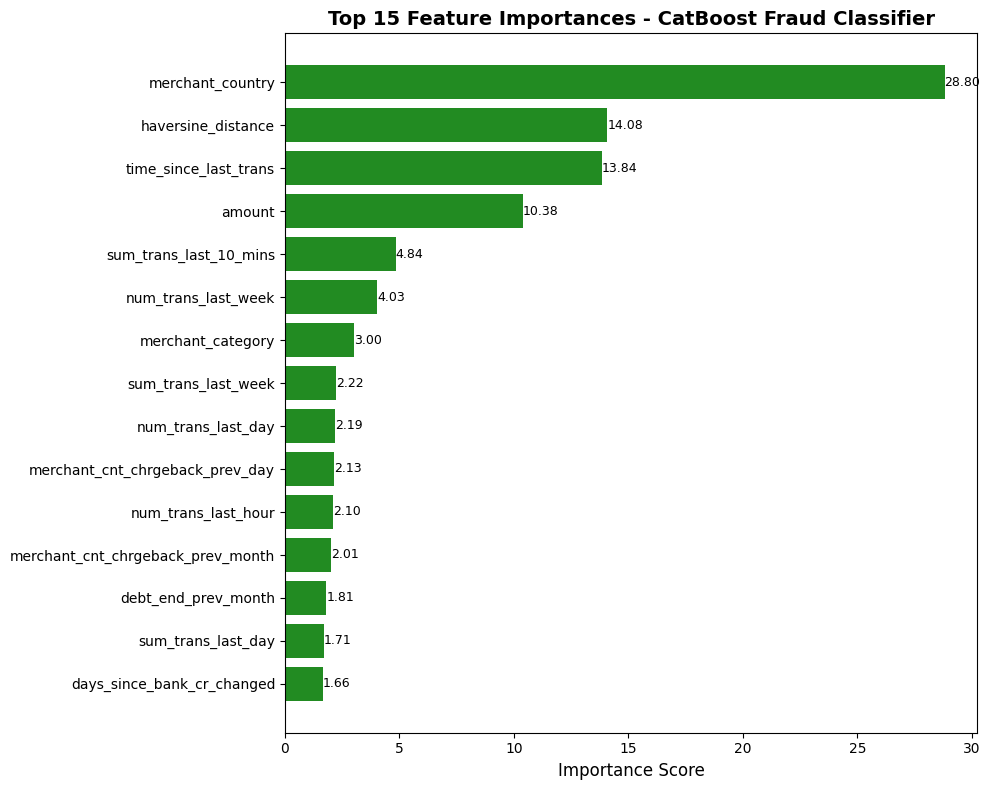


Interpretation:
Features with higher importance scores have more influence on fraud predictions.
CatBoost can directly use categorical features like merchant_category and country.


In [15]:
import matplotlib.pyplot as plt

# Get feature importance from CatBoost
feature_importance = pd.DataFrame({
    'feature': feature_names_out,
    'importance': catboost_model.get_feature_importance()
}).sort_values('importance', ascending=False)

# Display top 15 features
print("=" * 80)
print("TOP 15 MOST IMPORTANT FEATURES")
print("=" * 80)
print(feature_importance.head(15).to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
bars = ax.barh(top_features['feature'], top_features['importance'], color='forestgreen')
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 15 Feature Importances - CatBoost Fraud Classifier', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_features['importance'])):
    ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
            va='center', ha='left', fontsize=9, color='black')

plt.tight_layout()
feature_imp_fig = fig
plt.show()

print("\nInterpretation:")
print("Features with higher importance scores have more influence on fraud predictions.")
print("CatBoost can directly use categorical features like merchant_category and country.")

## Confusion Matrix

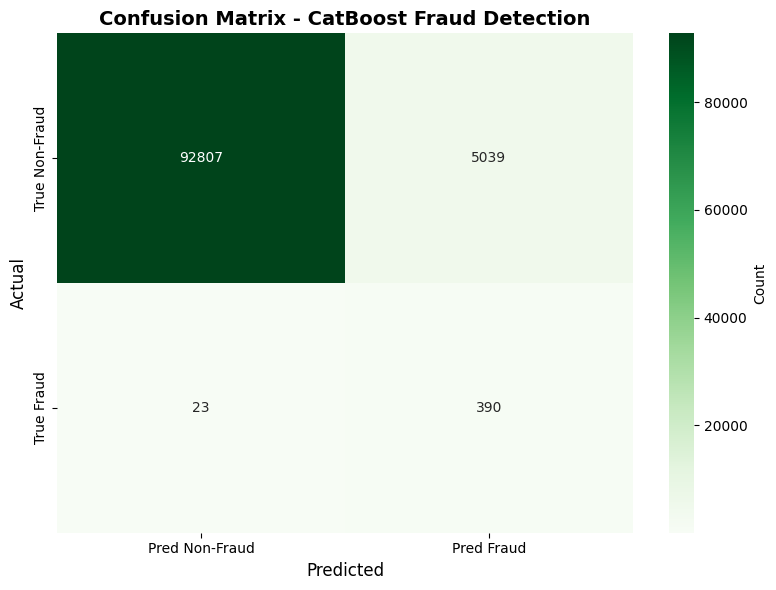

CONFUSION MATRIX BREAKDOWN
True Negatives:  92,807 (correctly identified non-fraud)
False Positives: 5,039 (non-fraud flagged as fraud)
False Negatives:    23 (fraud missed - CRITICAL)
True Positives:    390 (correctly identified fraud)

Key Insights:
  This represents 5.6% of all actual frauds.
  5039 legitimate transactions were flagged as fraud (false alarms).
  This is 5.15% of all legitimate transactions.


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predictions on the test set
y_pred = catboost_model.predict(X_test_processed)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
df_cm = pd.DataFrame(cm, 
                     index=['True Non-Fraud', 'True Fraud'],
                     columns=['Pred Non-Fraud', 'Pred Fraud'])

sns.heatmap(df_cm, annot=True, fmt='d', cmap='Greens', ax=ax, cbar_kws={'label': 'Count'})
ax.set_title('Confusion Matrix - CatBoost Fraud Detection', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
cm_fig = fig
plt.show()

# Print confusion matrix breakdown
print("=" * 80)
print("CONFUSION MATRIX BREAKDOWN")
print("=" * 80)
print(f"True Negatives:  {cm[0,0]:5,} (correctly identified non-fraud)")
print(f"False Positives: {cm[0,1]:5,} (non-fraud flagged as fraud)")
print(f"False Negatives: {cm[1,0]:5,} (fraud missed - CRITICAL)")
print(f"True Positives:  {cm[1,1]:5,} (correctly identified fraud)")

print("\nKey Insights:")
if cm[1,0] > 0:
    print(f"  WARNING: {cm[1,0]} fraudulent transactions were missed!")
    print(f"  This represents {cm[1,0]/(cm[1,0]+cm[1,1])*100:.1f}% of all actual frauds.")
if cm[0,1] > 0:
    print(f"  {cm[0,1]} legitimate transactions were flagged as fraud (false alarms).")
    print(f"  This is {cm[0,1]/(cm[0,0]+cm[0,1])*100:.2f}% of all legitimate transactions.")

## Classification Metrics

In [17]:
from sklearn.metrics import (
    classification_report, 
    precision_recall_curve, auc,
    precision_score, recall_score, f1_score
)

# Classification report
print("=" * 80)
print("CLASSIFICATION REPORT")
print("=" * 80)
report_dict = classification_report(y_test, y_pred, 
                                   target_names=['Non-Fraud', 'Fraud'],
                                   output_dict=True)
print(classification_report(y_test, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Calculate key metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Precision-Recall AUC (more important than ROC-AUC for imbalanced data)
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall_curve, precision_curve)

print("=" * 80)
print("KEY METRICS SUMMARY")
print("=" * 80)
print(f"PR-AUC Score:         {pr_auc:.4f}  <- More important for imbalanced data")
print(f"Precision (Fraud):    {precision:.4f}")
print(f"Recall (Fraud):       {recall:.4f}")
print(f"F1-Score (Fraud):     {f1:.4f}")

# Store metrics for model registry
metrics_dict = {
    'pr_auc': pr_auc,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'accuracy': report_dict['accuracy']
}

print("\nInterpretation:")
print(f"  - Precision: {precision*100:.1f}% of predicted frauds are actually fraudulent")
print(f"  - Recall: {recall*100:.1f}% of actual frauds were detected")
print(f"  - PR-AUC: {pr_auc:.4f} measures precision-recall tradeoff (higher is better)")

# Compare with XGBoost baseline targets
print("\n" + "=" * 80)
print("COMPARISON WITH XGBOOST BASELINE")
print("=" * 80)
print(f"PR-AUC:  {pr_auc:.4f} (target: > 0.51)  {'PASS' if pr_auc > 0.51 else 'NEEDS IMPROVEMENT'}")
print(f"Recall:  {recall:.4f} (target: > 0.88)  {'PASS' if recall > 0.88 else 'NEEDS IMPROVEMENT'}")
print(f"F1:      {f1:.4f} (target: > 0.24)  {'PASS' if f1 > 0.24 else 'NEEDS IMPROVEMENT'}")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.95      0.97     97846
       Fraud       0.07      0.94      0.13       413

    accuracy                           0.95     98259
   macro avg       0.54      0.95      0.55     98259
weighted avg       1.00      0.95      0.97     98259

KEY METRICS SUMMARY
PR-AUC Score:         0.5082  <- More important for imbalanced data
Precision (Fraud):    0.0718
Recall (Fraud):       0.9443
F1-Score (Fraud):     0.1335

Interpretation:
  - Precision: 7.2% of predicted frauds are actually fraudulent
  - Recall: 94.4% of actual frauds were detected
  - PR-AUC: 0.5082 measures precision-recall tradeoff (higher is better)

COMPARISON WITH XGBOOST BASELINE
PR-AUC:  0.5082 (target: > 0.51)  NEEDS IMPROVEMENT
Recall:  0.9443 (target: > 0.88)  PASS
F1:      0.1335 (target: > 0.24)  NEEDS IMPROVEMENT


## Save Model Artifacts

In [18]:
import os

model_dir = "cc_fraud_catboost_model"
images_dir = model_dir + "/images"
os.makedirs(images_dir, exist_ok=True)

print("\nModel artifacts will be saved to:", model_dir)


Model artifacts will be saved to: cc_fraud_catboost_model


In [19]:
import joblib

print("=" * 80)
print("SAVING MODEL ARTIFACTS")
print("=" * 80)

# Save trained CatBoost model
model_path = model_dir + "/cc_fraud_catboost.pkl"
joblib.dump(catboost_model, model_path)
print(f"Model saved to: {model_path}")

# Save preprocessing pipeline (imputation only)
preprocessor_path = model_dir + "/preprocessor.pkl"
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor pipeline saved to: {preprocessor_path}")

# Save confusion matrix image
cm_fig.savefig(images_dir + "/confusion_matrix.png", dpi=100, bbox_inches='tight')
print(f"Confusion matrix saved to: {images_dir}/confusion_matrix.png")

# Save feature importance image  
feature_imp_fig.savefig(images_dir + "/feature_importance.png", dpi=100, bbox_inches='tight')
print(f"Feature importance saved to: {images_dir}/feature_importance.png")

print("\n" + "=" * 80)
print("ALL ARTIFACTS SAVED SUCCESSFULLY")
print("=" * 80)
print(f"  - Model: cc_fraud_catboost.pkl")
print(f"  - Preprocessor: preprocessor.pkl (imputation only - no encoding needed!)")
print(f"  - Visualizations: 2 PNG files")
print("\nFor inference: preprocessor.pkl -> transform data -> catboost model -> predict")

SAVING MODEL ARTIFACTS
Model saved to: cc_fraud_catboost_model/cc_fraud_catboost.pkl
Preprocessor pipeline saved to: cc_fraud_catboost_model/preprocessor.pkl
Confusion matrix saved to: cc_fraud_catboost_model/images/confusion_matrix.png
Feature importance saved to: cc_fraud_catboost_model/images/feature_importance.png

ALL ARTIFACTS SAVED SUCCESSFULLY
  - Model: cc_fraud_catboost.pkl
  - Preprocessor: preprocessor.pkl (imputation only - no encoding needed!)
  - Visualizations: 2 PNG files

For inference: preprocessor.pkl -> transform data -> catboost model -> predict


In [20]:
# Add the CatBoost predictor script to the model's directory
predictor_script="ccfraud-catboost-predictor.py"
src = Path(f"notebooks/{predictor_script}")
dst_dir = Path(model_dir)
try:
    shutil.copy(src, dst_dir / src.name)
except:
    src = Path(predictor_script)
    shutil.copy(src, dst_dir / src.name)

## Register Model in Hopsworks

In [21]:
print("=" * 80)
print("REGISTERING CATBOOST MODEL IN HOPSWORKS")
print("=" * 80)

# Format metrics for model registry (must be numeric strings only!)
metrics_for_registry = {
    'pr_auc': f"{metrics_dict['pr_auc']:.4f}",
    'precision': f"{metrics_dict['precision']:.4f}",
    'recall': f"{metrics_dict['recall']:.4f}",
    'f1_score': f"{metrics_dict['f1_score']:.4f}",
    'accuracy': f"{metrics_dict['accuracy']:.4f}",
    'n_train_samples': str(len(y_train)),
    'n_fraud_train': str(n_positive),
    'imbalance_ratio': f"{imbalance_ratio:.2f}"
}

print("Model metadata:")
for key, value in metrics_for_registry.items():
    print(f"  {key:20s}: {value}")

model_name = "cc_fraud_catboost_model"
# Create model in registry
cc_fraud_catboost = mr.python.create_model(
    name=model_name,
    metrics=metrics_for_registry,
    feature_view=fv,
    description="Credit Card Fraud Detection - CatBoost Binary Classifier with auto_class_weights='Balanced'. "
                f"Trained on {len(y_train):,} samples with {n_positive} fraud cases. "
                f"Uses {len(feature_names_out)} features with native categorical support."
)

# Upload model directory to registry
cc_fraud_catboost.save(model_dir)

print("\n" + "=" * 80)
print("MODEL REGISTRATION COMPLETE")
print("=" * 80)
print(f"Model name: {model_name}")
print(f"Version: {cc_fraud_catboost.version}")

REGISTERING CATBOOST MODEL IN HOPSWORKS
Model metadata:
  pr_auc              : 0.5082
  precision           : 0.0718
  recall              : 0.9443
  f1_score            : 0.1335
  accuracy            : 0.9485
  n_train_samples     : 358937
  n_fraud_train       : 1866
  imbalance_ratio     : 191.36


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/cc_fraud_catboost_model/preprocessor.pkl: 0.000%…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/cc_fraud_catboost_model/ccfraud-catboost-predict…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/cc_fraud_catboost_model/cc_fraud_catboost.pkl: 0…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/cc_fraud_catboost_model/images/confusion_matrix.…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/cc_fraud_catboost_model/images/feature_importanc…

Uploading /home/jdowling/Projects/mlfs-book/ccfraud/notebooks/model_schema.json: 0.000%|          | 0/2146 ela…

Model created, explore it at https://eu-west.cloud.hopsworks.ai:443/p/120/models/cc_fraud_catboost_model/4

MODEL REGISTRATION COMPLETE
Model name: cc_fraud_catboost_model
Version: 4


In [22]:
ms = proj.get_model_serving()
best_model = mr.get_best_model(name=model_name, metric="f1_score", direction="max")

# If the model I trained is better than the existing model deployment, replace it with this one
if best_model.version == cc_fraud_catboost.version:
    print(f"This is the best model version at: {best_model.version_path}")
    predictor_path = os.path.join(best_model.version_path, f"Files/{predictor_script}")
    deployment_name = "ccfraudcatboost"  # No hyphens allowed in deployment names
    try:
        deployment = ms.get_deployment(deployment_name)
        deployment.delete(force=True)
        print(f"Deleted deployment {deployment_name}")
    except:
        print("Deployment not running")
    deployment = best_model.deploy(name=deployment_name, 
                                   script_file=predictor_path, 
                                   environment="pandas-inference-pipeline"
                                  )
    deployment.start(await_running=180)
    deployment_state = deployment.get_state().describe()
else:
    print("Not deploying this model, as its performance is worse than the existing deployment")

Not deploying this model, as its performance is worse than the existing deployment
